# **Installing necessary libraries**

In [ ]:
! pip install qiskit
! pip install qiskit-aer

# **Importing necessary libraries**

In [6]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

# **Test circuit**

In [24]:
# System Specification
n_qubits = 4
circ = QuantumCircuit(n_qubits)

# Test Circuit
circ.h(0)
circ.x(0)
circ.y(0)
for qubit in range(n_qubits - 1):
    circ.cy(qubit, qubit + 1)
    circ.cx(qubit, qubit + 1)
    circ.cz(qubit, qubit + 1)
circ.measure_all()
print(circ)

        ┌───┐┌───┐┌───┐                                        ░ ┌─┐         
   q_0: ┤ H ├┤ X ├┤ Y ├──■────■───■────────────────────────────░─┤M├─────────
        └───┘└───┘└───┘┌─┴─┐┌─┴─┐ │                            ░ └╥┘┌─┐      
   q_1: ───────────────┤ Y ├┤ X ├─■───■────■───■───────────────░──╫─┤M├──────
                       └───┘└───┘   ┌─┴─┐┌─┴─┐ │               ░  ║ └╥┘┌─┐   
   q_2: ────────────────────────────┤ Y ├┤ X ├─■───■────■───■──░──╫──╫─┤M├───
                                    └───┘└───┘   ┌─┴─┐┌─┴─┐ │  ░  ║  ║ └╥┘┌─┐
   q_3: ─────────────────────────────────────────┤ Y ├┤ X ├─■──░──╫──╫──╫─┤M├
                                                 └───┘└───┘    ░  ║  ║  ║ └╥┘
meas: 4/══════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                  0  1  2  3 


# **Ideal Simulation**
Simulating the above test circuit in an ideal (noise-free) condition.

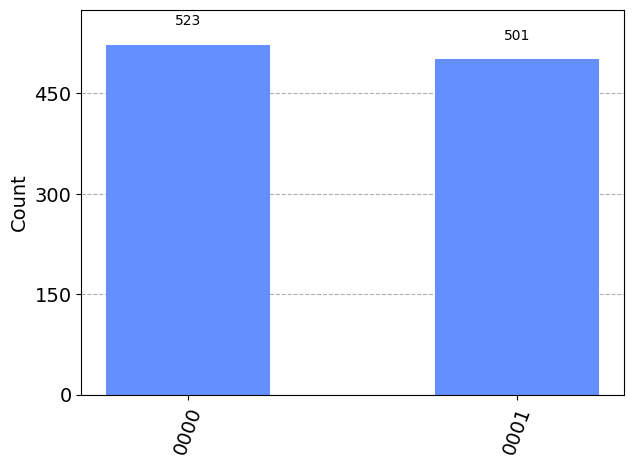

In [27]:
# Ideal simulator and execution
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circ).result()
plot_histogram(result_ideal.get_counts(0))

# **T1/T2 thermal relaxation noise model**

In [25]:
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u2', 'u3']
  Instructions with noise: ['u3', 'cx', 'measure', 'reset', 'u2']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (2, 0)), ('cx', (2, 1)), ('cx', (2, 2)), ('cx', (2, 3)), ('cx', (3, 0)), ('cx', (3, 1)), ('cx', (3, 2)), ('cx', (3, 3))]


# **Executing the above noisy model**

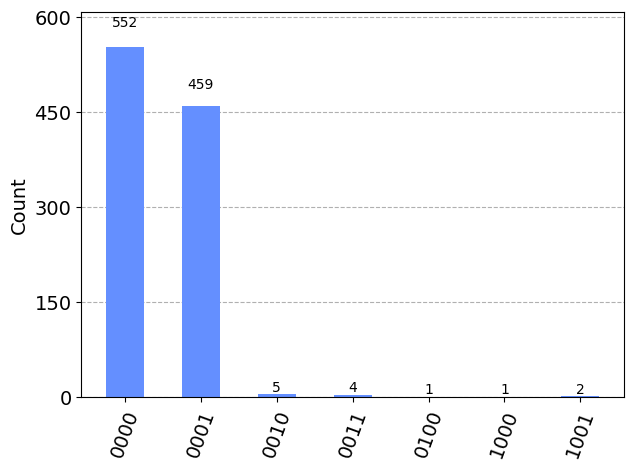

In [26]:
# Run the noisy simulation
sim_thermal = AerSimulator(noise_model=noise_thermal)

# Transpile circuit for noisy basis gates
circ_tthermal = transpile(circ, sim_thermal)

# Run and get counts
result_thermal = sim_thermal.run(circ_tthermal).result()
counts_thermal = result_thermal.get_counts(0)

# Plot noisy output
plot_histogram(counts_thermal)

# **Integrating Readout, Bit-Flip and Thermal Relaxation Errors into a Quantum Circuit**

        ┌───┐┌───┐┌───┐                                        ░ ┌─┐         
   q_0: ┤ H ├┤ X ├┤ Y ├──■────■───■────────────────────────────░─┤M├─────────
        └───┘└───┘└───┘┌─┴─┐┌─┴─┐ │                            ░ └╥┘┌─┐      
   q_1: ───────────────┤ Y ├┤ X ├─■───■────■───■───────────────░──╫─┤M├──────
                       └───┘└───┘   ┌─┴─┐┌─┴─┐ │               ░  ║ └╥┘┌─┐   
   q_2: ────────────────────────────┤ Y ├┤ X ├─■───■────■───■──░──╫──╫─┤M├───
                                    └───┘└───┘   ┌─┴─┐┌─┴─┐ │  ░  ║  ║ └╥┘┌─┐
   q_3: ─────────────────────────────────────────┤ Y ├┤ X ├─■──░──╫──╫──╫─┤M├
                                                 └───┘└───┘    ░  ║  ║  ║ └╥┘
meas: 4/══════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                  0  1  2  3 


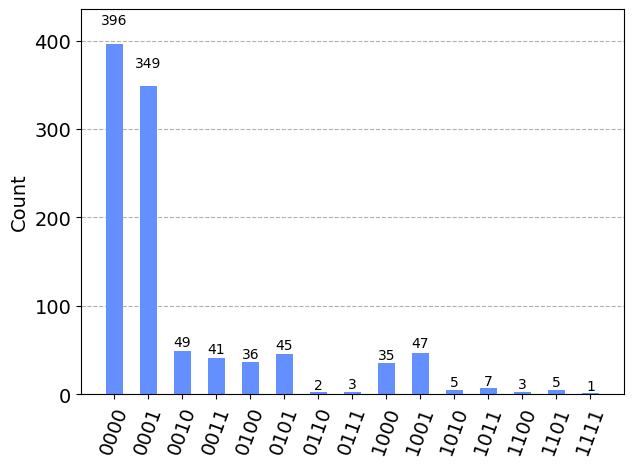

In [31]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error

# Readout Error
# Measurement miss-assignment probabilities
p0given1 = 0.1
p1given0 = 0.05

readout_error = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])

# Bit-flip Error
# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X', p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X', p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])

# Thermal Relaxation Error
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4)
T2s = np.random.normal(70e3, 10e3, 4)
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0
time_u2 = 50
time_u3 = 100
time_cx = 300
time_reset = 1000
time_measure = 1000

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset) for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure) for t1, t2 in zip(T1s, T2s)]
errors_u1 = [thermal_relaxation_error(t1, t2, time_u1) for t1, t2 in zip(T1s, T2s)]
errors_u2 = [thermal_relaxation_error(t1, t2, time_u2) for t1, t2 in zip(T1s, T2s)]
errors_u3 = [thermal_relaxation_error(t1, t2, time_u3) for t1, t2 in zip(T1s, T2s)]
errors_cx = [
    [
        thermal_relaxation_error(t1a, t2a, time_cx).expand(thermal_relaxation_error(t1b, t2b, time_cx))
        for t1a, t2a in zip(T1s, T2s)
    ]
    for t1b, t2b in zip(T1s, T2s)
]

# Add errors to noise model
for j in range(4):
    noise_model.add_quantum_error(errors_reset[j], "reset", [j])
    noise_model.add_quantum_error(errors_measure[j], "measure", [j])
    noise_model.add_quantum_error(errors_u1[j], "u1", [j])
    noise_model.add_quantum_error(errors_u2[j], "u2", [j])
    noise_model.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_model.add_quantum_error(errors_cx[j][k], "cx", [j, k])

# System Specification
n_qubits = 4
circ = QuantumCircuit(n_qubits)

# Test Circuit
circ.h(0)
circ.x(0)
circ.y(0)
for qubit in range(n_qubits - 1):
    circ.cy(qubit, qubit + 1)
    circ.cx(qubit, qubit + 1)
    circ.cz(qubit, qubit + 1)
circ.measure_all()
print(circ)

# Ideal simulator and execution
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circ).result()
plot_histogram(result_ideal.get_counts(0))

# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_model)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(circ, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)

# Run the noisy simulation with thermal relaxation error
sim_thermal = AerSimulator(noise_model=noise_model)

# Transpile circuit for noisy basis gates
circ_tthermal = transpile(circ, sim_thermal)

# Run and get counts
result_thermal = sim_thermal.run(circ_tthermal).result()
counts_thermal = result_thermal.get_counts(0)

# Plot noisy output
plot_histogram(counts_thermal)